In [1]:
import pandas as pd
import numpy as np
import scipy.io
import h5py
import mne
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression


### Examining the structures inside the EEG_full

In [2]:
# Load the .mat file
file_path = "/kaggle/input/arousal/S01_C_OLoop.mat"  # Update with correct path
mat_data = h5py.File(file_path, 'r')

# Check if 'actualVariable' exists
if 'actualVariable' in mat_data:
    actual_var = mat_data['actualVariable']
    print("Keys inside actualVariable:", list(actual_var.keys()))
    
    # Check if 'EEG_full' exists inside 'actualVariable'
    if 'EEG_full' in actual_var:
        eeg_full = actual_var['EEG_full']
        print("Keys inside EEG_full:", list(eeg_full.keys()))
    else:
        print("'EEG_full' not found inside 'actualVariable'")
else:
    print("'actualVariable' not found in the dataset")


Keys inside actualVariable: ['EEG_full']
Keys inside EEG_full: ['chaninfo', 'chanlocs', 'comments', 'condition', 'data', 'dipfit', 'epoch', 'epochdescription', 'etc', 'event', 'eventdescription', 'filename', 'filepath', 'group', 'history', 'icaact', 'icachansind', 'icasphere', 'icasplinefile', 'icaweights', 'icawinv', 'nbchan', 'pnts', 'ref', 'reject', 'saved', 'session', 'setname', 'specdata', 'specicaact', 'splinefile', 'srate', 'stats', 'subject', 'times', 'trials', 'urchanlocs', 'urevent', 'xmax', 'xmin']


### Examining the chaninfo

In [3]:
if 'chaninfo' in eeg_full:
    eeg_data = eeg_full['chaninfo']
    print("Keys inside chaninfo:", list(eeg_data.keys()))
else:
    print("'data' not found inside 'EEG_full'")


Keys inside chaninfo: ['filecontent', 'filename', 'icachansind', 'nodatchans', 'nosedir', 'plotrad', 'shrink']


### Examining chanlocs

In [4]:
if 'chanlocs' in eeg_full:
    eeg_data = eeg_full['chanlocs']
    print("Keys inside chanlocs:", list(eeg_data.keys()))
else:
    print("'data' not found inside 'EEG_full'")


Keys inside chanlocs: ['X', 'Y', 'Z', 'labels', 'radius', 'ref', 'sph_phi', 'sph_radius', 'sph_theta', 'theta', 'type', 'urchan']


### Combining the chanlocs

In [5]:
# Extract channel labels
channel_labels = []

chanlocs = eeg_full['chanlocs']

for ref in chanlocs['labels']:
    obj = mat_data[ref[0]]  # Dereference
    label = ''.join(map(chr, obj[:].flatten()))  # Convert to string
    channel_labels.append(label)

def extract_data(ref_array):
    """Extracts numeric data from HDF5 references, ensuring uniform shape."""
    values = []
    
    for ref in ref_array:
        obj = mat_data[ref[0]]  # Dereference
        
        data = obj[()]  # Extract value(s)
        if isinstance(data, np.ndarray):  
            data = data.flatten()  # Ensure it's 1D
            if data.size == 1:
                values.append(data[0])  # Append single value
            else:
                values.append(list(data))  # Append list if multiple values
        else:
            values.append(data)  # Append scalar directly
    
    return values  # Return list instead of NumPy array

# Convert fields into lists of numerical values
df_chanlocs = pd.DataFrame({
    "Channel": channel_labels,
    "X": extract_data(chanlocs['X']),
    "Y": extract_data(chanlocs['Y']),
    "Z": extract_data(chanlocs['Z']),
    "Theta": extract_data(chanlocs['theta']),
    "Sph_Phi": extract_data(chanlocs['sph_phi']),
    "Sph_Theta": extract_data(chanlocs['sph_theta']),
    "Sph_Radius": extract_data(chanlocs['sph_radius'])
})

print(channel_labels)

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'ECG', 'HR', 'HR-delta', 'HR-delta-abs', 'HRV-pNN35', 'RESP', 'EDA', 'EDAz', 'EDA-phasic', 'EDA-SMNA', 'EDA-tonic', 'PUP-L', 'PUP-R', 'PORX', 'PORY', 'PORX-L', 'PORY-L', 'PORX-R', 'PORY-R', 'EYE-Time', 'EYE-Validity', 'PUP-int-L', 'PUP-int-R', 'PORX-int', 'PORY-int', 'PORX-int-L', 'PORY-int-L', 'PORX-int-R', 'PORY-int-R', 'PUP-conv05-4-L', 'PUP-conv05-4-R', 'PUP-logbp06-L', 'PUP-logbp06-R', 'Sac-Amp-Avg', 'Sac-Angle-Abs-Avg', 'Sac-Dur-Avg', 'Sac-VMax-Avg', 'Fix-Dur-Avg', 'Sac-rate-pmin', 'Fix-rate-pmin', 'Blink-rate-pmin', 'Joy-Pitch', 'Joy-Roll', 'Joy-Pitch-acc', 'Joy-Roll-ac

### Electrode placement

In [6]:
# Keep only rows where X, Y, Z are numbers (filter out metadata)
df_cleaned = df_chanlocs[df_chanlocs["X"].apply(lambda x: isinstance(x, float))]

df_cleaned


,Channel,X,Y,Z,Theta,Sph_Phi,Sph_Theta,Sph_Radius
0,Fp1,0.950477,0.308829,-0.034899,-18.0,-2.0,18.0,1.0
1,AF7,0.787531,0.615286,-0.034899,-38.0,-2.0,38.0,1.0
2,AF3,0.884846,0.375595,0.275637,-23.0,16.0,23.0,1.0
3,F1,0.710264,0.286965,0.642788,-22.0,40.0,22.0,1.0
4,F3,0.673028,0.545007,0.5,-39.0,30.0,39.0,1.0
...,...,...,...,...,...,...,...,...
59,P8,-0.587427,-0.808524,-0.034899,126.0,-2.0,-126.0,1.0
60,P10,-0.532714,-0.733218,-0.422618,126.0,-25.0,-126.0,1.0
61,PO8,-0.808524,-0.587427,-0.034899,144.0,-2.0,-144.0,1.0
62,PO4,-0.884846,-0.375595,0.275637,157.0,16.0,-157.0,1.0


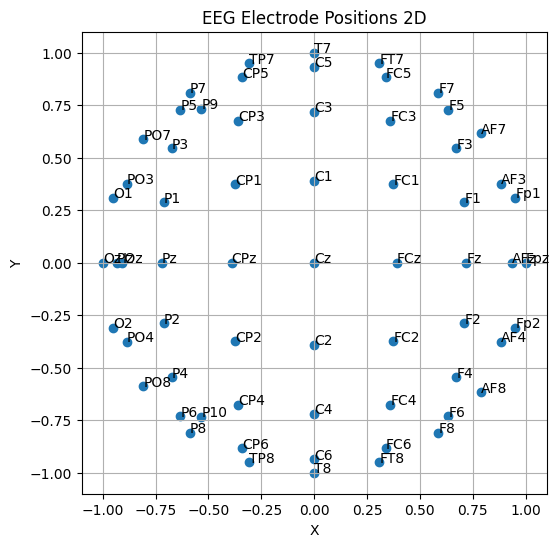

In [7]:
# Plot the electrode positions
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_cleaned['X'], df_cleaned['Y'], label='Electrodes')

for i, label in enumerate(df_cleaned['Channel']):
    ax.annotate(label, (df_cleaned['X'][i], df_cleaned['Y'][i]))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('EEG Electrode Positions 2D')
plt.grid(True)
plt.savefig("channel_positions.png")
plt.show()


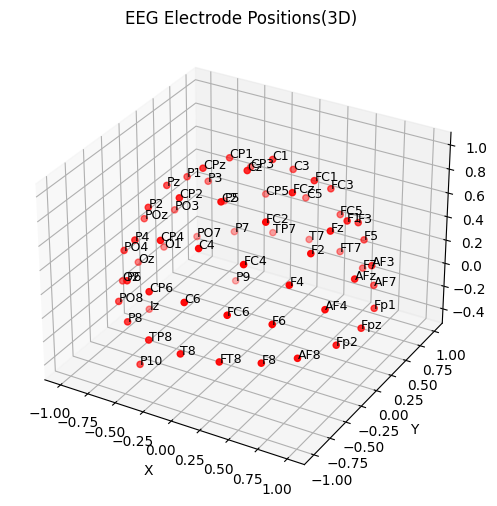

In [8]:
# Visualizing electrode placement



fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract valid coordinates
x, y, z = df_cleaned["X"], df_cleaned["Y"], df_cleaned["Z"]

# Scatter plot
ax.scatter(x, y, z, c='r', marker='o')

# Label the points
for i, channel in enumerate(df_cleaned["Channel"]):
    ax.text(x.iloc[i], y.iloc[i], z.iloc[i], channel, fontsize=9)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("EEG Electrode Positions(3D)")
plt.savefig("3d_channel_positions.png")
plt.show()


### Checking the labels

In [9]:
labels = extract_data(eeg_full['chanlocs']['labels'])
pd.DataFrame(labels)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,70,112,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65,70,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65,70,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,70,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,70,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,70,108,105.0,103.0,104.0,116.0,45.0,116.0,105.0,109.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,67,111,117.0,114.0,115.0,101.0,45.0,116.0,121.0,112.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,70,66,45.0,116.0,121.0,112.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,82,105,110.0,103.0,45.0,116.0,121.0,112.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Obtaining the data

In [10]:
if 'data' in eeg_full:
    eeg_data = eeg_full['data']
    eeg_data = pd.DataFrame(eeg_data)
    eeg_data

### Converting the data to a pandas dataframe

In [11]:

# Assign column names
eeg_data.columns = channel_labels

# Display the first few rows
x = type(eeg_data)
print(x)

<class 'pandas.core.frame.DataFrame'>


In [12]:


# Define the folder containing the .mat files
input_folder = "/kaggle/input/arousal"  # Replace with your folder path
output_folder_C_OLoop = "csv_C_OLoop"
output_folder_CL_Sil_50_100 = "csv_CL_Sil_50_100"

# Create output directories if they don't exist
os.makedirs(output_folder_C_OLoop, exist_ok=True)
os.makedirs(output_folder_CL_Sil_50_100, exist_ok=True)

# Loop through the files from S01 to S20
for subject_number in range(1, 21):
    # Construct the file paths for both files
    c_oloop_file = f"S{subject_number:02d}_C_OLoop.mat"
    cl_sil_50_100_file = f"S{subject_number:02d}_F_CL_Sil_50_100.mat"
    
    # Check if the files exist in the folder
    for mat_file in [c_oloop_file, cl_sil_50_100_file]:
        mat_file_path = os.path.join(input_folder, mat_file)
        if os.path.exists(mat_file_path):
            with h5py.File(mat_file_path, "r") as f:
                # Navigate through the structure
                actual_variable = f["actualVariable"]
                eeg_full = actual_variable["EEG_full"]
                data = eeg_full["data"]
                
                # Convert to NumPy array
                data_array = np.array(data)
                
                # Assuming the channel labels are available (modify accordingly)
                channel_labels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'ECG', 'HR', 'HR-delta', 'HR-delta-abs', 'HRV-pNN35', 'RESP', 'EDA', 'EDAz', 'EDA-phasic', 'EDA-SMNA', 'EDA-tonic', 'PUP-L', 'PUP-R', 'PORX', 'PORY', 'PORX-L', 'PORY-L', 'PORX-R', 'PORY-R', 'EYE-Time', 'EYE-Validity', 'PUP-int-L', 'PUP-int-R', 'PORX-int', 'PORY-int', 'PORX-int-L', 'PORY-int-L', 'PORX-int-R', 'PORY-int-R', 'PUP-conv05-4-L', 'PUP-conv05-4-R', 'PUP-logbp06-L', 'PUP-logbp06-R', 'Sac-Amp-Avg', 'Sac-Angle-Abs-Avg', 'Sac-Dur-Avg', 'Sac-VMax-Avg', 'Fix-Dur-Avg', 'Sac-rate-pmin', 'Fix-rate-pmin', 'Blink-rate-pmin', 'Joy-Pitch', 'Joy-Roll', 'Joy-Pitch-acc', 'Joy-Roll-acc', 'Joy-Pitch-pw', 'Joy-Roll-pw', 'Joy-Pitch-pw016-3', 'Joy-Roll-pw016-3', 'Joy-Pitch-pw3plus', 'Joy-Roll-pw3plus', 'Joy-Pitch-pw0016', 'Joy-Roll-pw0016', 'BCI-raw', 'FB-HB-0-1', 'FB-HB-0-1-nrm', 'FB-HB-raw', 'FB-Mix-fact', 'Shm-2-2', 'Shm-raw', 'Plane-pos-len', 'Plane-pos-height', 'Path-steps', 'Path-low', 'Path-high', 'Path-width', 'Path-avg', 'Path-avg-2s-smooth', 'Head-raw-x', 'Head-raw-y', 'Head-raw-z', 'Head-x', 'Head-y', 'Head-z', 'Condition', 'Flight-time', 'Course-type', 'FB-type', 'Ring-type', 'LSL-time']
                
                # Convert to DataFrame
                df = pd.DataFrame(data_array)
                df.columns = channel_labels  # Assign proper channel labels
                
                # Save to appropriate folder and file name
                if "C_OLoop" in mat_file:
                    csv_file_path = os.path.join(output_folder_C_OLoop, f"S{subject_number:02d}_C_OLoop.csv")
                else:
                    csv_file_path = os.path.join(output_folder_CL_Sil_50_100, f"S{subject_number:02d}_F_CL_Sil_50_100.csv")
                
                # Save DataFrame to CSV
                df.to_csv(csv_file_path, index=False)
                print(f"Data successfully saved to {csv_file_path}")


Data successfully saved to csv_C_OLoop/S01_C_OLoop.csv
Data successfully saved to csv_CL_Sil_50_100/S01_F_CL_Sil_50_100.csv
Data successfully saved to csv_C_OLoop/S02_C_OLoop.csv
Data successfully saved to csv_CL_Sil_50_100/S02_F_CL_Sil_50_100.csv
Data successfully saved to csv_C_OLoop/S03_C_OLoop.csv
Data successfully saved to csv_CL_Sil_50_100/S03_F_CL_Sil_50_100.csv
Data successfully saved to csv_C_OLoop/S04_C_OLoop.csv
Data successfully saved to csv_CL_Sil_50_100/S04_F_CL_Sil_50_100.csv
Data successfully saved to csv_C_OLoop/S05_C_OLoop.csv
Data successfully saved to csv_CL_Sil_50_100/S05_F_CL_Sil_50_100.csv
Data successfully saved to csv_C_OLoop/S06_C_OLoop.csv
Data successfully saved to csv_CL_Sil_50_100/S06_F_CL_Sil_50_100.csv
Data successfully saved to csv_C_OLoop/S07_C_OLoop.csv
Data successfully saved to csv_CL_Sil_50_100/S07_F_CL_Sil_50_100.csv
Data successfully saved to csv_C_OLoop/S08_C_OLoop.csv
Data successfully saved to csv_CL_Sil_50_100/S08_F_CL_Sil_50_100.csv
Data suc

In [13]:


# Define input folders
input_folders = ["/kaggle/working/csv_C_OLoop", "/kaggle/working/csv_CL_Sil_50_100"]

# Define physiological columns to be removed
physiological_columns = ['ECG', 'HR', 'HR-delta', 'HR-delta-abs', 'HRV-pNN35', 'RESP', 'EDA', 'EDAz', 'EDA-phasic', 'EDA-SMNA', 'EDA-tonic',
                          'PUP-L', 'PUP-R', 'PORX', 'PORY', 'PORX-L', 'PORY-L', 'PORX-R', 'PORY-R', 'EYE-Time', 'EYE-Validity', 'PUP-int-L', 'PUP-int-R',
                          'PORX-int', 'PORY-int', 'PORX-int-L', 'PORY-int-L', 'PORX-int-R', 'PORY-int-R', 'PUP-conv05-4-L', 'PUP-conv05-4-R', 'PUP-logbp06-L',
                          'PUP-logbp06-R', 'Sac-Amp-Avg', 'Sac-Angle-Abs-Avg', 'Sac-Dur-Avg', 'Sac-VMax-Avg', 'Fix-Dur-Avg', 'Sac-rate-pmin', 'Fix-rate-pmin',
                          'Blink-rate-pmin', 'Joy-Pitch', 'Joy-Roll', 'Joy-Pitch-acc', 'Joy-Roll-acc', 'Joy-Pitch-pw', 'Joy-Roll-pw', 'Joy-Pitch-pw016-3',
                          'Joy-Roll-pw016-3', 'Joy-Pitch-pw3plus', 'Joy-Roll-pw3plus', 'Joy-Pitch-pw0016', 'Joy-Roll-pw0016', 'BCI-raw', 'FB-HB-0-1', 'FB-HB-0-1-nrm',
                          'FB-HB-raw', 'FB-Mix-fact', 'Shm-2-2', 'Shm-raw', 'Plane-pos-len', 'Plane-pos-height', 'Path-steps', 'Path-low', 'Path-high', 'Path-width',
                          'Path-avg', 'Path-avg-2s-smooth', 'Head-raw-x', 'Head-raw-y', 'Head-raw-z', 'Head-x', 'Head-y', 'Head-z', 'Condition', 'Flight-time',
                          'Course-type', 'FB-type', 'Ring-type', 'LSL-time']

# Process each folder
for folder in input_folders:
    for filename in os.listdir(folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder, filename)
            df = pd.read_csv(file_path)
            
            # Create arousal_level column
            df['arousal_level'] = df[['HR', 'HRV-pNN35', 'RESP', 'EDA']].mean(axis=1)
            # df['arousal_level'] = df['arousal_level'] % 1890000  # Apply modulus operation
            
            # Remove physiological columns
            df.drop(columns=physiological_columns, inplace=True, errors='ignore')
            
            # Extract EEG channels (Fp1 to P10) and arousal_level
            eeg_channels = df.loc[:, 'Fp1':'P10']
            final_dataset = pd.concat([eeg_channels, df[['arousal_level']]], axis=1)
            
            # Save the processed file back to the same location
            final_dataset.to_csv(file_path, index=False)
            print(f"Processed and saved: {file_path}")

Processed and saved: /kaggle/working/csv_C_OLoop/S12_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S06_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S04_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S01_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S20_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S16_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S18_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S08_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S17_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S09_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S15_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S10_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S07_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S03_C_OLoop.csv
Processed and saved: /kaggle/working/csv_C_OLoop/S02_C_OLoop.csv
Processed and saved: /kag

In [14]:
# # Check for NaN or infinite values
# print("Missing values:", np.isnan(eeg_data).sum())
# print("Infinite values:", np.isinf(eeg_data).sum())

### Sampling rate

In [15]:

# sampling_rate = mat_data['actualVariable']['EEG_full']['srate'][()]
# print("Sampling Rate:", sampling_rate)


In [16]:
# import h5py
# import numpy as np
# import pandas as pd
# import os
# import matplotlib.pyplot as plt

# # Define the directory containing the .mat files
# data_dir = "/kaggle/input/arousal/"

# # Get all .mat files in the directory
# file_paths = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(".mat")]

# # Dictionary to store time of flight data for plotting
# time_of_flight_dict = {}

# for file_path in file_paths:
#     # Load the .mat file
#     mat_data = h5py.File(file_path, 'r')

#     # Navigate to the correct dataset structure
#     if 'actualVariable' in mat_data:
#         actual_var = mat_data['actualVariable']
        
#         # Check if 'EEG_full' exists
#         if 'EEG_full' in actual_var:
#             eeg_data = actual_var['EEG_full']
            
#             # Compute time of flight: dataset size / 250
#             time_of_flight = eeg_data.shape[1] / 250  
            
#             # Extract subject ID from filename (e.g., "S01_C_OLoop.mat" -> "S01")
#             subject_id = os.path.basename(file_path).split("_")[0]
            
#             # Store the computed time of flight
#             time_of_flight_dict[subject_id] = time_of_flight
#         else:
#             print(f"'EEG_full' not found in {file_path}")
#     else:
#         print(f"'actualVariable' not found in {file_path}")

# # Convert dictionary to DataFrame for further analysis
# df_time_of_flight = pd.DataFrame(list(time_of_flight_dict.items()), columns=["Subject", "Time_of_Flight"])

# # Display the DataFrame
# print(df_time_of_flight)

# # Plot the time of flight for each subject
# plt.figure(figsize=(10, 5))
# plt.bar(df_time_of_flight["Subject"], df_time_of_flight["Time_of_Flight"], color="royalblue")

# plt.xlabel("Subject")
# plt.ylabel("Time of Flight (s)")
# plt.title("Time of Flight Across Subjects")
# plt.grid(axis="y", linestyle="--")

# # Save the plot before showing
# plt.savefig("../working/time_of_flight_plot.png", dpi=300)
# plt.show()


In [17]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming df_cleaned is your DataFrame with EEG data
# # List of EEG channel names
# channels = df_cleaned['Channel'].tolist()

# # Select only the EEG channels and the time column (if applicable)
# time_column = eeg_data.index  # Assuming the index is the time or you could use a specific column if you have a 'time' column.
# eeg_data = eeg_data[channels]

# # Plot all EEG waveforms on the same graph
# plt.figure(figsize=(12, 8))

# for channel in channels:
#     plt.plot(time_column, eeg_data[channel], label=channel)

# # Add labels and title
# plt.xlabel('Time (samples)')
# plt.ylabel('Amplitude (µV)')
# plt.title('EEG Waveforms for All Channels')
# plt.grid(True)

# # Add a legend to differentiate the channels
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.savefig("waveforms.png")
# plt.show()

In [18]:
# from scipy import signal
# import matplotlib.pyplot as plt

# # Example for a single channel
# fs = 250  # Sampling frequency
# f, t, Sxx = signal.spectrogram(eeg_data['C3'], fs)
# plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Spectrogram for C3')
# plt.colorbar(label='Intensity [dB]')
# plt.savefig("spectogram_c3.png")
# plt.show()

In [19]:
# from scipy import signal
# import matplotlib.pyplot as plt

# # Example for a single channel
# f, Pxx = signal.welch(eeg_data['C3'], fs=250, nperseg=1024)
# plt.semilogy(f, Pxx)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Power Spectral Density [V**2/Hz]')
# plt.title('Power Spectral Density for C3')
# plt.grid(True)
# plt.show()

In [20]:
# import mne
# import numpy as np

# # Example data
# data = np.random.randn(64)  # Example data for 32 channels
# info = mne.create_info(ch_names=channels, sfreq=250, ch_types='eeg')
# evoked = mne.EvokedArray(data[:, np.newaxis], info)

# # Plot topographic map
# evoked.plot_topomap(times=[0], size=3, show=True)

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import signal

# # Example for a single channel
# t = np.linspace(0, 1, 500, endpoint=False)
# sig = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)
# frequencies, times, Sxx = signal.spectrogram(sig, fs=250)

# plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Time-Frequency Analysis')
# plt.colorbar(label='Intensity [dB]')
# plt.savefig("Time_frequency.png")
# plt.show()

In [22]:
# import matplotlib.pyplot as plt

# # Example: Averaging across trials for a specific channel
# erp = eeg_data.groupby('event').mean()['C3']
# plt.plot(erp)
# plt.xlabel('Time (samples)')
# plt.ylabel('Amplitude (µV)')
# plt.title('Event-Related Potential for C3')
# plt.grid(True)
# plt.show()

In [23]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Compute correlation matrix
# corr_matrix = eeg_data.corr()

# # Plot heatmap
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.title('Channel Correlation Heatmap')
# plt.savefig("channel_correlation.png")
# plt.show()

In [24]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plot boxplot
# sns.boxplot(data=eeg_data)
# plt.xlabel('Channels')
# plt.ylabel('Amplitude (µV)')
# plt.title('Boxplot of Channel Amplitudes')
# plt.savefig("Boxplot.png")
# plt.show()

In [25]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# # Example data
# X, Y = np.meshgrid(time_column, channels)
# Z = eeg_data.values.T

# # Plot 3D surface
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')
# ax.set_xlabel('Time (samples)')
# ax.set_ylabel('Channels')
# ax.set_zlabel('Amplitude (µV)')
# plt.title('3D Surface Plot of EEG Data')
# plt.show()

In [26]:
# Define paths
closed_loop_path = '/kaggle/working/csv_CL_Sil_50_100'
open_loop_path = '/kaggle/working/csv_C_OLoop'

# Exclude subjects 13 and 14
excluded_subjects = ['S13', 'S14']

# Initialize an empty list to store dataframes
dataframes = []

# Loop through all files in the closed-loop folder
for filename in os.listdir(closed_loop_path):
    # Check if the file is a CSV and not from excluded subjects
    if filename.endswith('.csv') and not any(subject in filename for subject in excluded_subjects):
        # Construct the full file path
        file_path = os.path.join(closed_loop_path, filename)
        # Read the CSV file
        df = pd.read_csv(file_path)
        # Add a column for subject ID
        df['subject'] = filename.split('_')[0]  # Extract subject ID from filename (e.g., S01)
        # Append the dataframe to the list
        dataframes.append(df)

# Combine all dataframes into one
combined_data = pd.concat(dataframes, ignore_index=True)

In [27]:
# Separate features (X) and target (y)
X = combined_data.drop(columns=['arousal_level', 'subject'])  # Drop target and subject ID
y = combined_data['arousal_level']  # Target column

# Normalize/standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add subject ID back to the scaled data for splitting
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled['subject'] = combined_data['subject']

In [28]:

# Get unique subjects
subjects = X_scaled['subject'].unique()

# First split: 70% train, 30% temporary (val + test)
train_subjects, temp_subjects = train_test_split(subjects, test_size=0.3, random_state=42)

# Second split: 50% val, 50% test (from the 30% temporary split)
val_subjects, test_subjects = train_test_split(temp_subjects, test_size=0.5, random_state=42)

# Print the number of subjects in each set
print(f"Train subjects: {len(train_subjects)}")
print(f"Validation subjects: {len(val_subjects)}")
print(f"Test subjects: {len(test_subjects)}")

Train subjects: 12
Validation subjects: 3
Test subjects: 3


In [29]:
# Split the data based on subjects
X_train = X_scaled[X_scaled['subject'].isin(train_subjects)].drop(columns=['subject'])
X_val = X_scaled[X_scaled['subject'].isin(val_subjects)].drop(columns=['subject'])
X_test = X_scaled[X_scaled['subject'].isin(test_subjects)].drop(columns=['subject'])

y_train = y[X_scaled['subject'].isin(train_subjects)]
y_val = y[X_scaled['subject'].isin(val_subjects)]
y_test = y[X_scaled['subject'].isin(test_subjects)]

In [30]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

# Initialize the model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = linear_model.predict(X_val)

# Evaluate the model
linear_metrics = evaluate_model(y_val, y_val_pred)

# Print results
print("Linear Regression (Validation Set):")
for metric, value in linear_metrics.items():
    print(f"  {metric}: {value:.4f}")

Linear Regression (Validation Set):
  MSE: 34730198695015.9883
  RMSE: 5893233.2972
  MAE: 5227220.0679
  R²: -0.4491


In [31]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Initialize models
models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Predict on validation set
    y_pred = model.predict(X_val)
    # Evaluate the model
    results[name] = evaluate_model(y_val, y_pred)

# Print results
for name, metrics in results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.917e+20, tolerance: 5.835e+16
  model = cd_fast.enet_coordinate_descent(


Ridge Regression:
  MSE: 34730134027430.8594
  RMSE: 5893227.8106
  MAE: 5227217.8720
  R²: -0.4491
Lasso Regression:
  MSE: 34725284948941.4336
  RMSE: 5892816.3851
  MAE: 5227054.8851
  R²: -0.4489


### Neural network 

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.2),  # Dropout for regularization
    Dense(32, activation='relu'),  # Hidden layer
    Dropout(0.2),  # Dropout for regularization
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer (no activation for regression)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,593 (25.75 KB)

 Trainable params: 6,593 (25.75 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Maximum number of epochs
    batch_size=32,  # Adjust based on your dataset size
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
116742/116742 ━━━━━━━━━━━━━━━━━━━━ 237s 2ms/step - loss: 309602180661248.0000 - mae: 11299856.0000 - val_loss: 33104121036800.0000 - val_mae: 5107259.5000
Epoch 2/100
116742/116742 ━━━━━━━━━━━━━━━━━━━━ 233s 2ms/step - loss: 163370640605184.0000 - mae: 9948445.0000 - val_loss: 31485157441536.0000 - val_mae: 4980546.0000
Epoch 3/100
116742/116742 ━━━━━━━━━━━━━━━━━━━━ 231s 2ms/step - loss: 163566363607040.0000 - mae: 9963304.0000 - val_loss: 33039365177344.0000 - val_mae: 5102502.0000
Epoch 4/100
116742/116742 ━━━━━━━━━━━━━━━━━━━━ 236s 2ms/step - loss: 162900727562240.0000 - mae: 9944194.0000 - val_loss: 33926355615744.0000 - val_mae: 5168816.0000
Epoch 5/100
116742/116742 ━━━━━━━━━━━━━━━━━━━━ 229s 2ms/step - loss: 162867860996096.0000 - mae: 9951498.0000 - val_loss: 33156694540288.0000 - val_mae: 5111373.0000
Epoch 6/100
116742/116742 ━━━━━━━━━━━━━━━━━━━━ 254s 2ms/step - loss: 162938744733696.0000 - mae: 9948602.0000 - val_loss: 32082552160256.0000 - val_mae: 5028438.0000
Epo

In [39]:
# Predict on the validation set
y_val_pred = model.predict(X_val).flatten()

# Evaluate the model
nn_metrics = evaluate_model(y_val, y_val_pred)

# Print results
print("Neural Network (Validation Set):")
for metric, value in nn_metrics.items():
    print(f"  {metric}: {value:.4f}")

33189/33189 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step
Neural Network (Validation Set):
  MSE: 31485137551991.0195
  RMSE: 5611161.8718
  MAE: 4980551.4540
  R²: -0.3137


In [32]:
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from sklearn.svm import SVR

# # Add more models
# models.update({
#     'Random Forest': RandomForestRegressor(random_state=42),
#     'XGBoost': XGBRegressor(random_state=42),
#     'SVR': SVR(kernel='rbf')
# })

# # Train and evaluate models
# for name, model in models.items():
#     if name not in results:  # Skip already trained models
#         # Train the model
#         model.fit(X_train, y_train)
#         # Predict on validation set
#         y_pred = model.predict(X_val)
#         # Evaluate the model
#         results[name] = evaluate_model(y_val, y_pred)

# # Print results
# for name, metrics in results.items():
#     print(f"{name}:")
#     for metric, value in metrics.items():
#         print(f"  {metric}: {value:.4f}")

In [33]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# # Define parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print(f"Best parameters: {best_params}")

# # Evaluate the best model on the validation set
# y_pred = best_model.predict(X_val)
# results['Random Forest (Tuned)'] = evaluate_model(y_val, y_pred)

# # Print results
# print("Random Forest (Tuned):")
# for metric, value in results['Random Forest (Tuned)'].items():
#     print(f"  {metric}: {value:.4f}")